In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def read_files(files):
    ret = []
    for f in files:
        ret += [pd.read_csv(f)]
    return ret

STATS_DIR = 'stats'
HASH_FUNCS = ['hash::zero', 'hash::firstChar', 'hash::strlen', 'hash::sum',
              'hash::ror', 'hash::rol', 'hash::crc32', 'hash::gnu']

stats = read_files([f'{STATS_DIR}/{hash_func}.csv' for hash_func in HASH_FUNCS])
nums = [st['num'] for st in stats]
loads = [st['load'] for st in stats]

In [30]:
def plot_hash_func(num, load_factor, title, xlim):
    plt.figure(figsize=(15, 4), dpi=200)
    plt.xlim(xlim)
    plt.bar(num, load_factor, color='red', width=1.5)
    plt.xlabel('Значение хеша')
    plt.ylabel('Число коллизий')
    plt.title(title)
    plt.savefig(f'graphs/{title}.png')

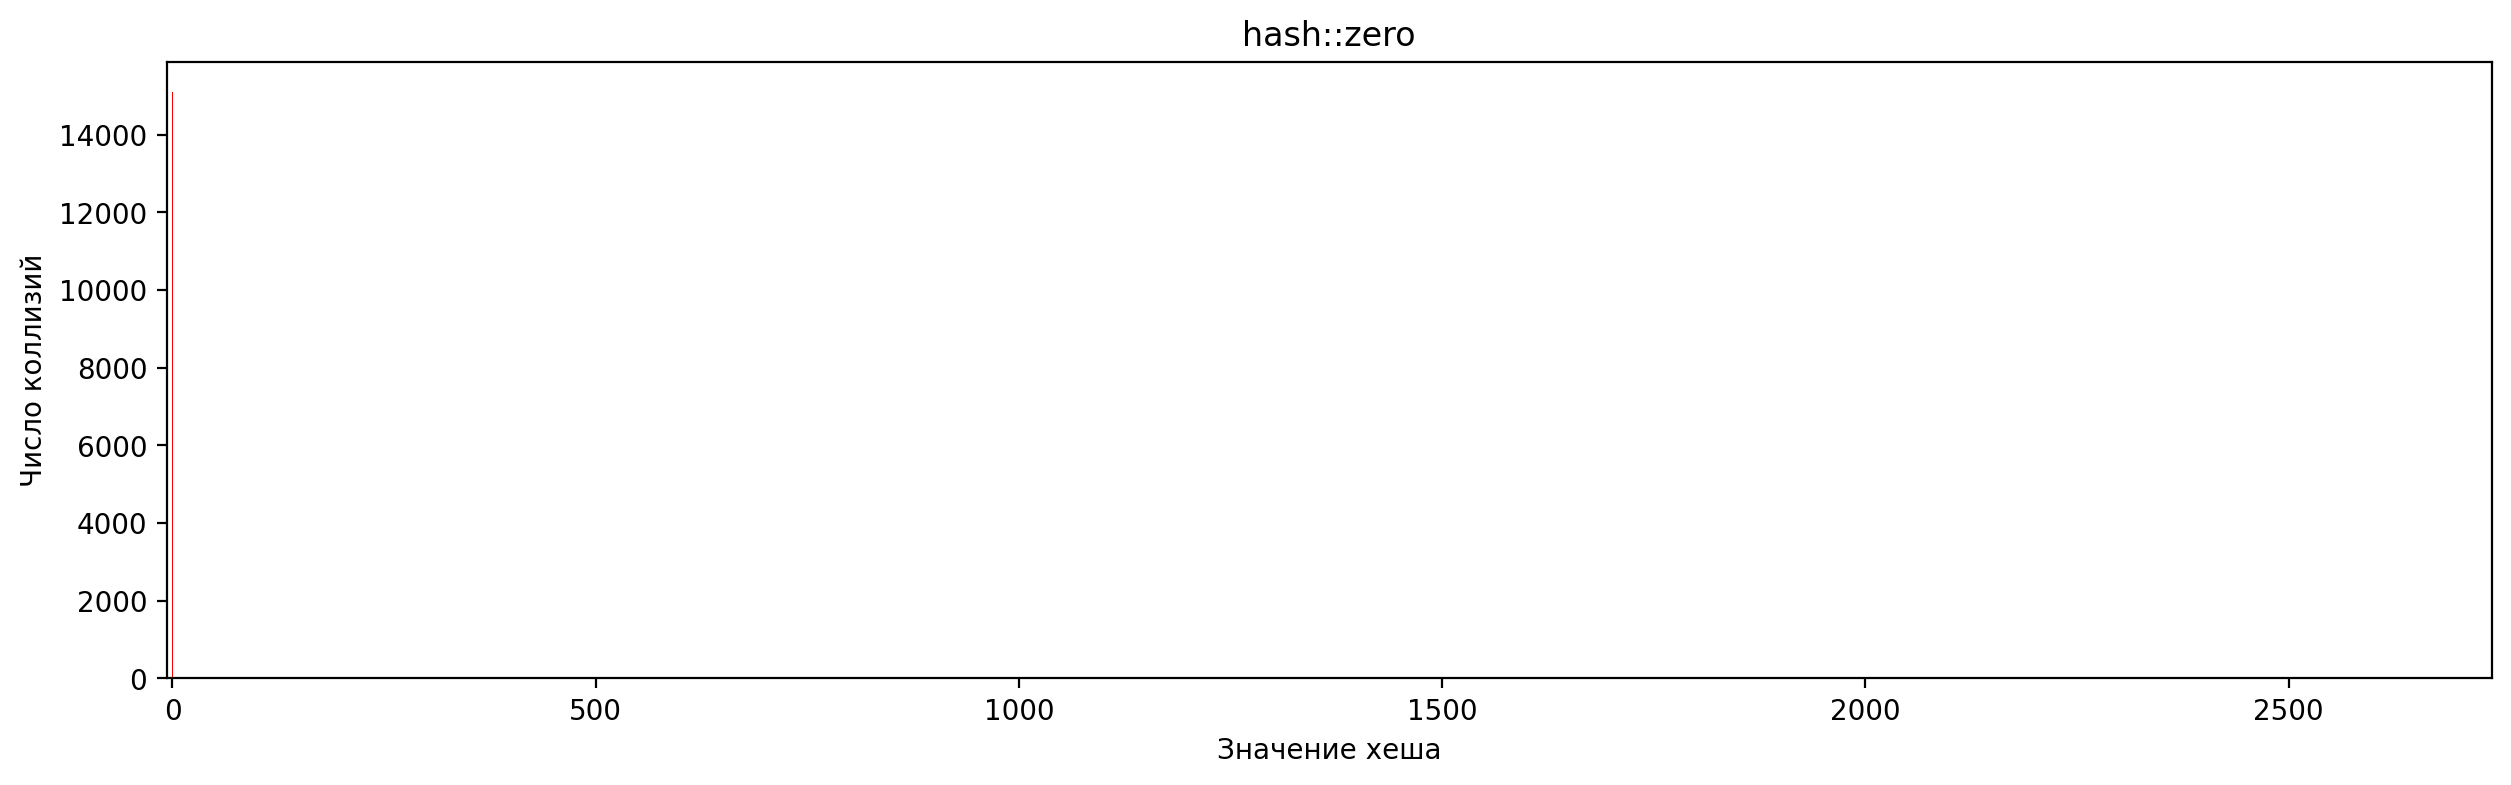

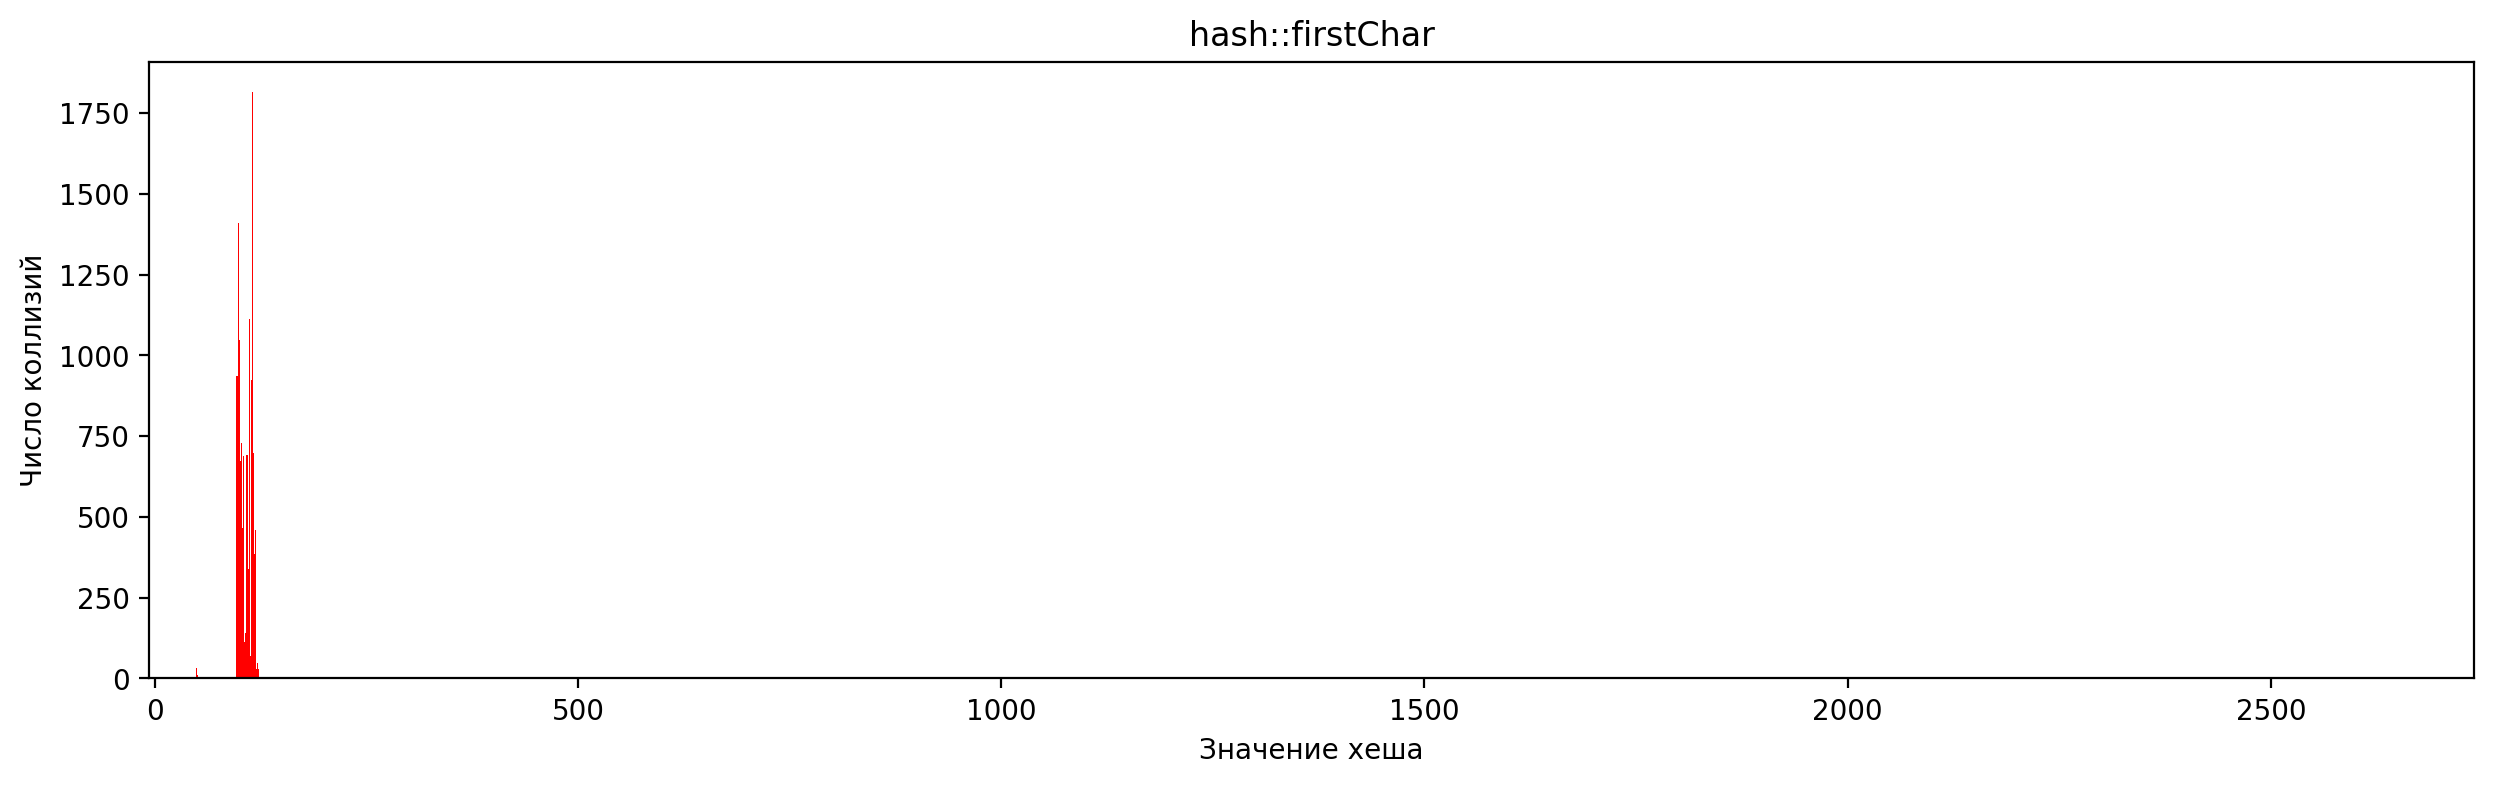

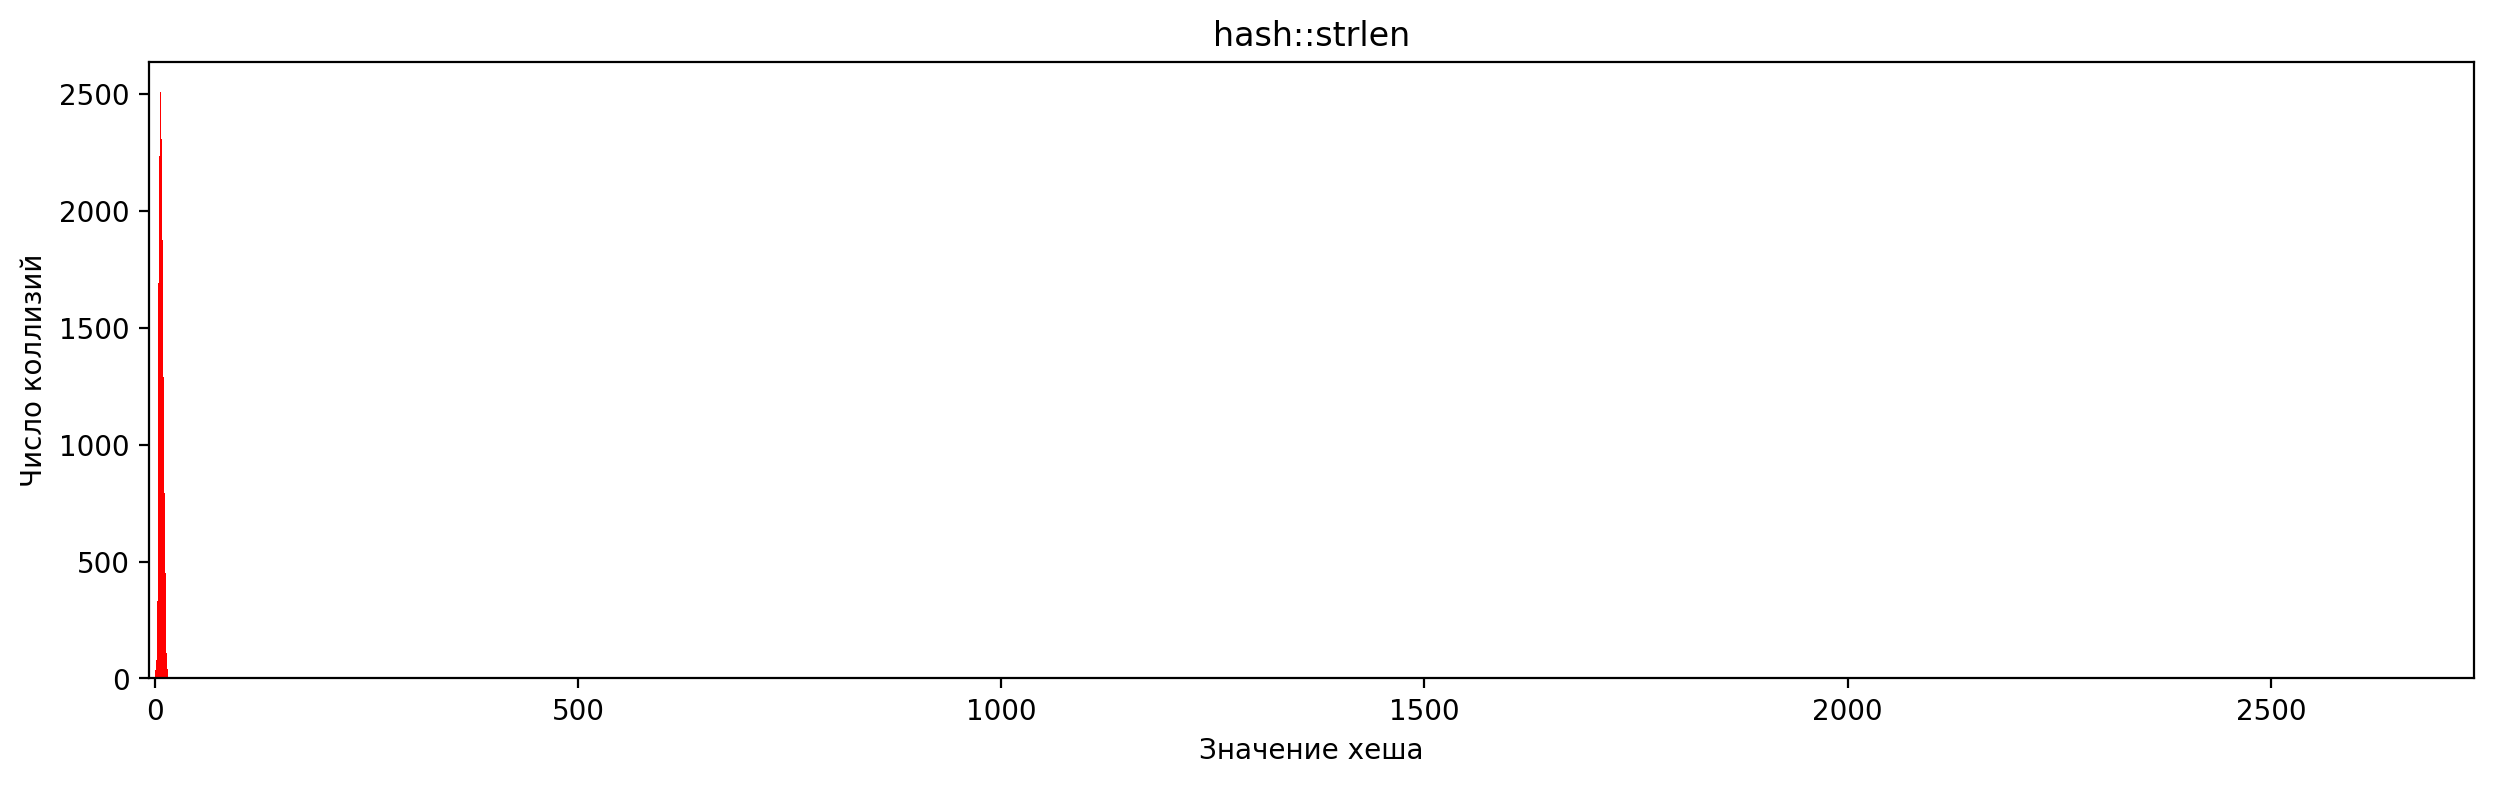

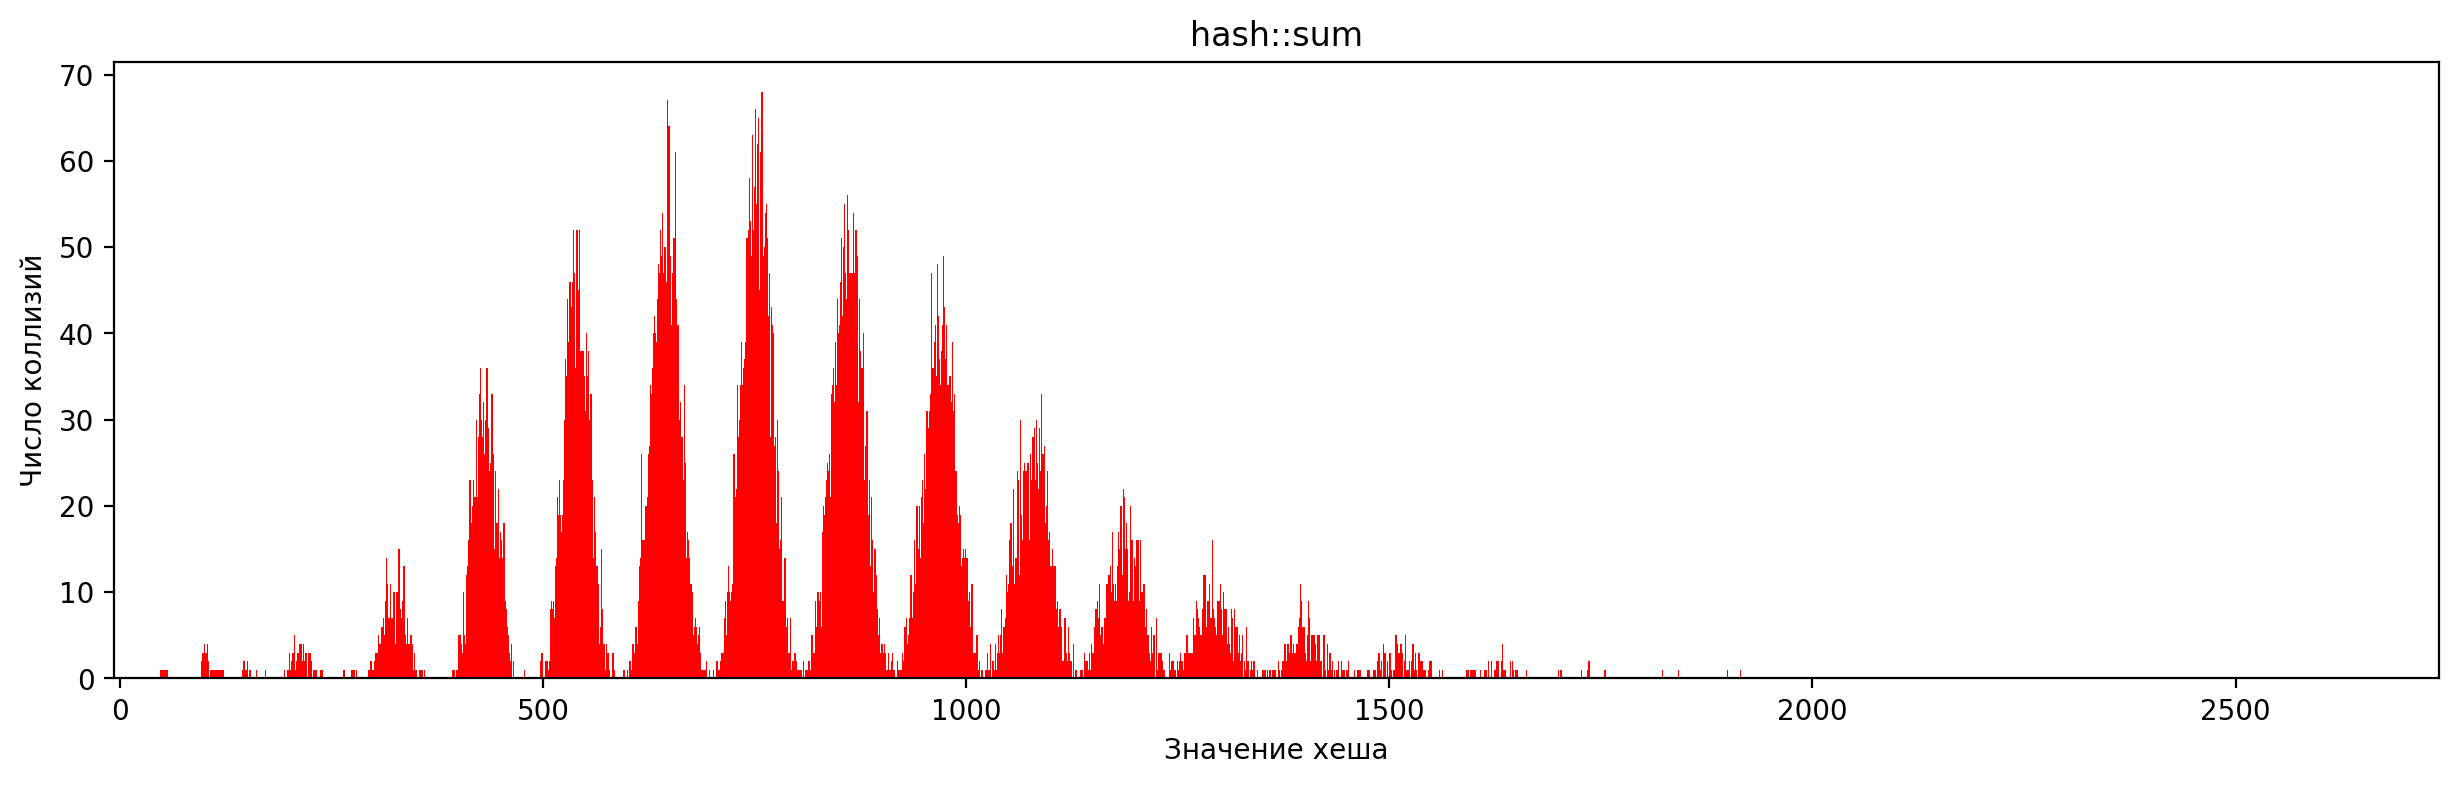

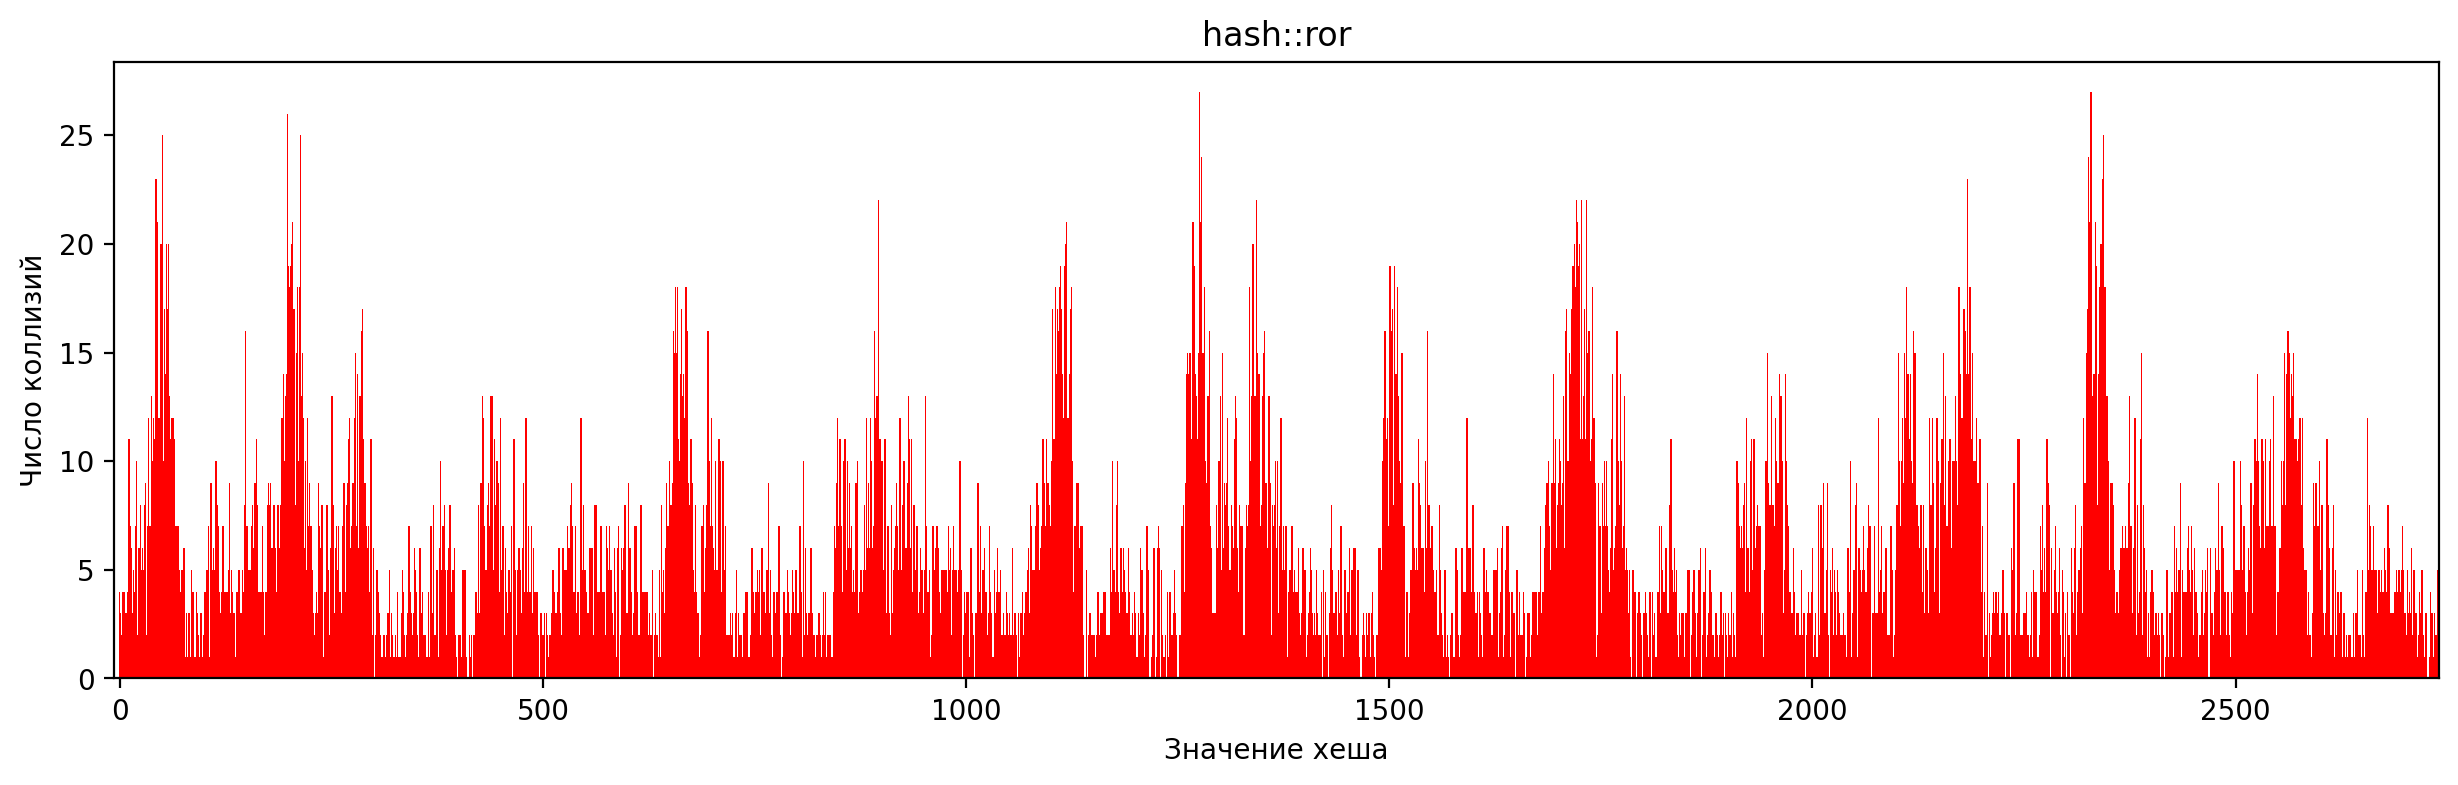

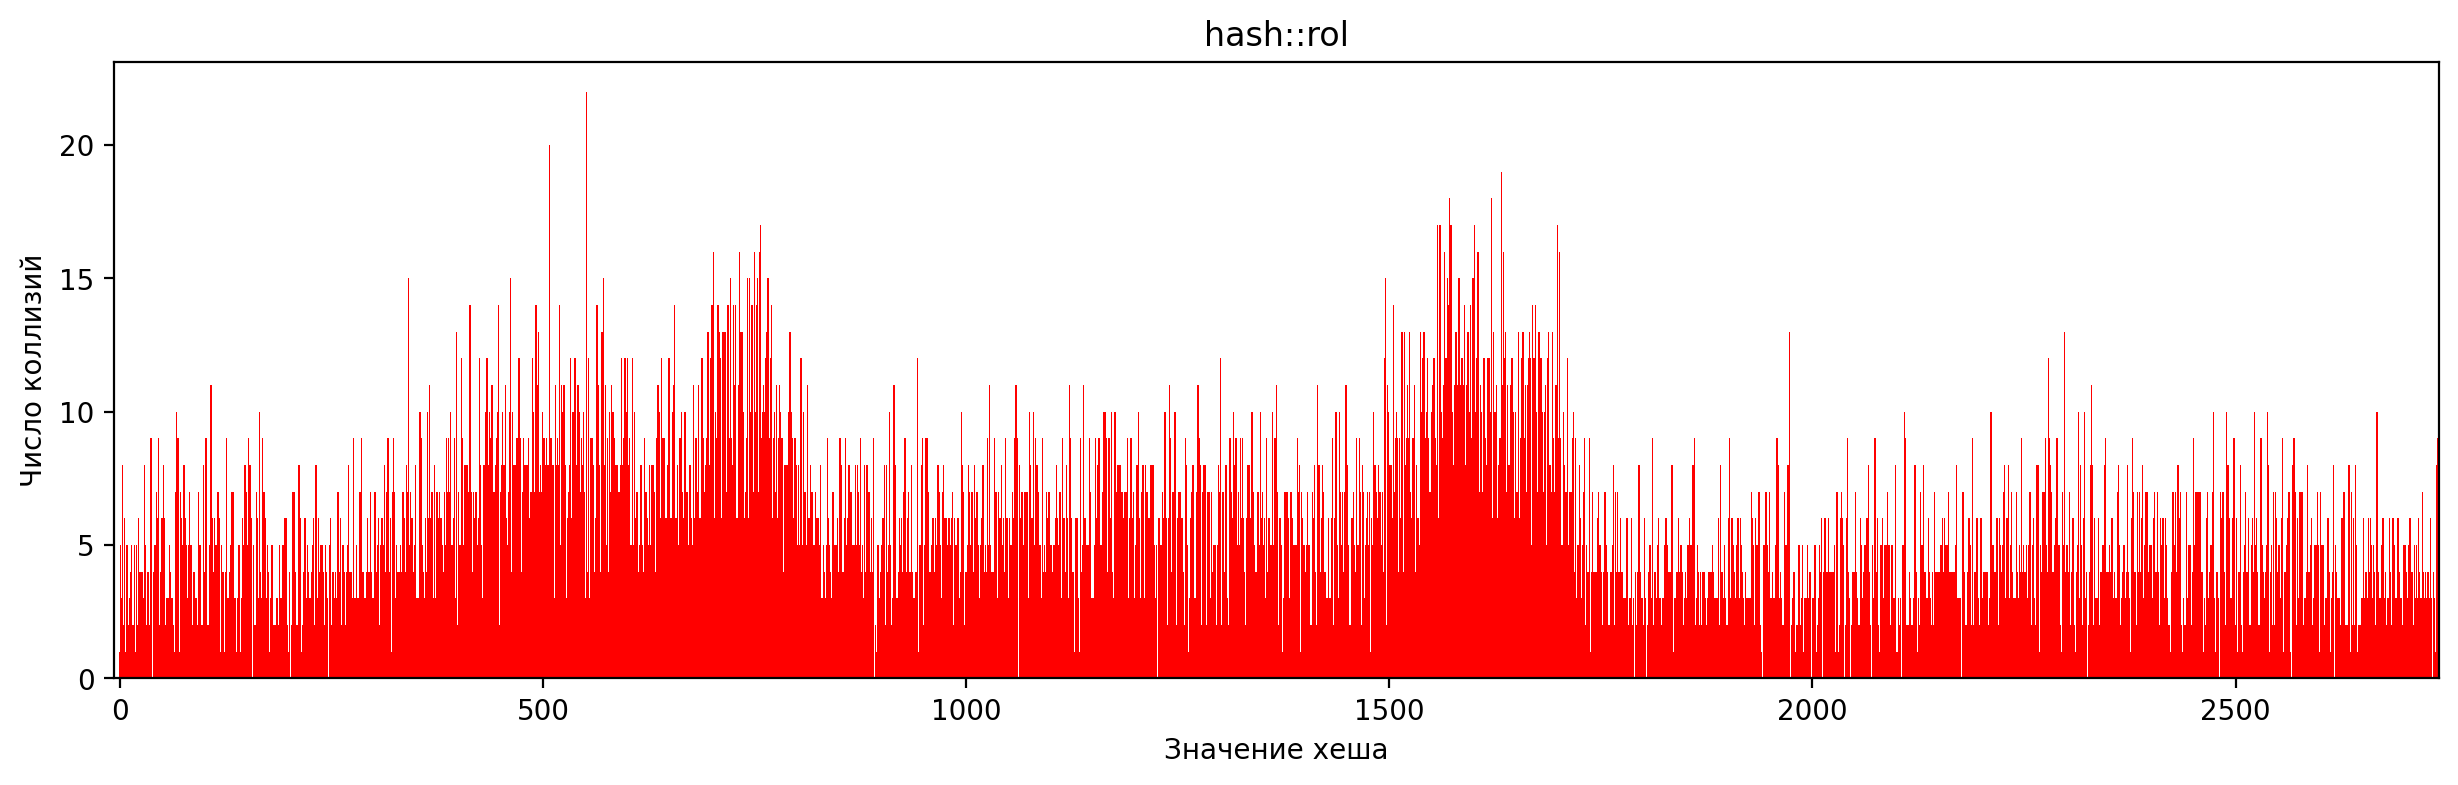

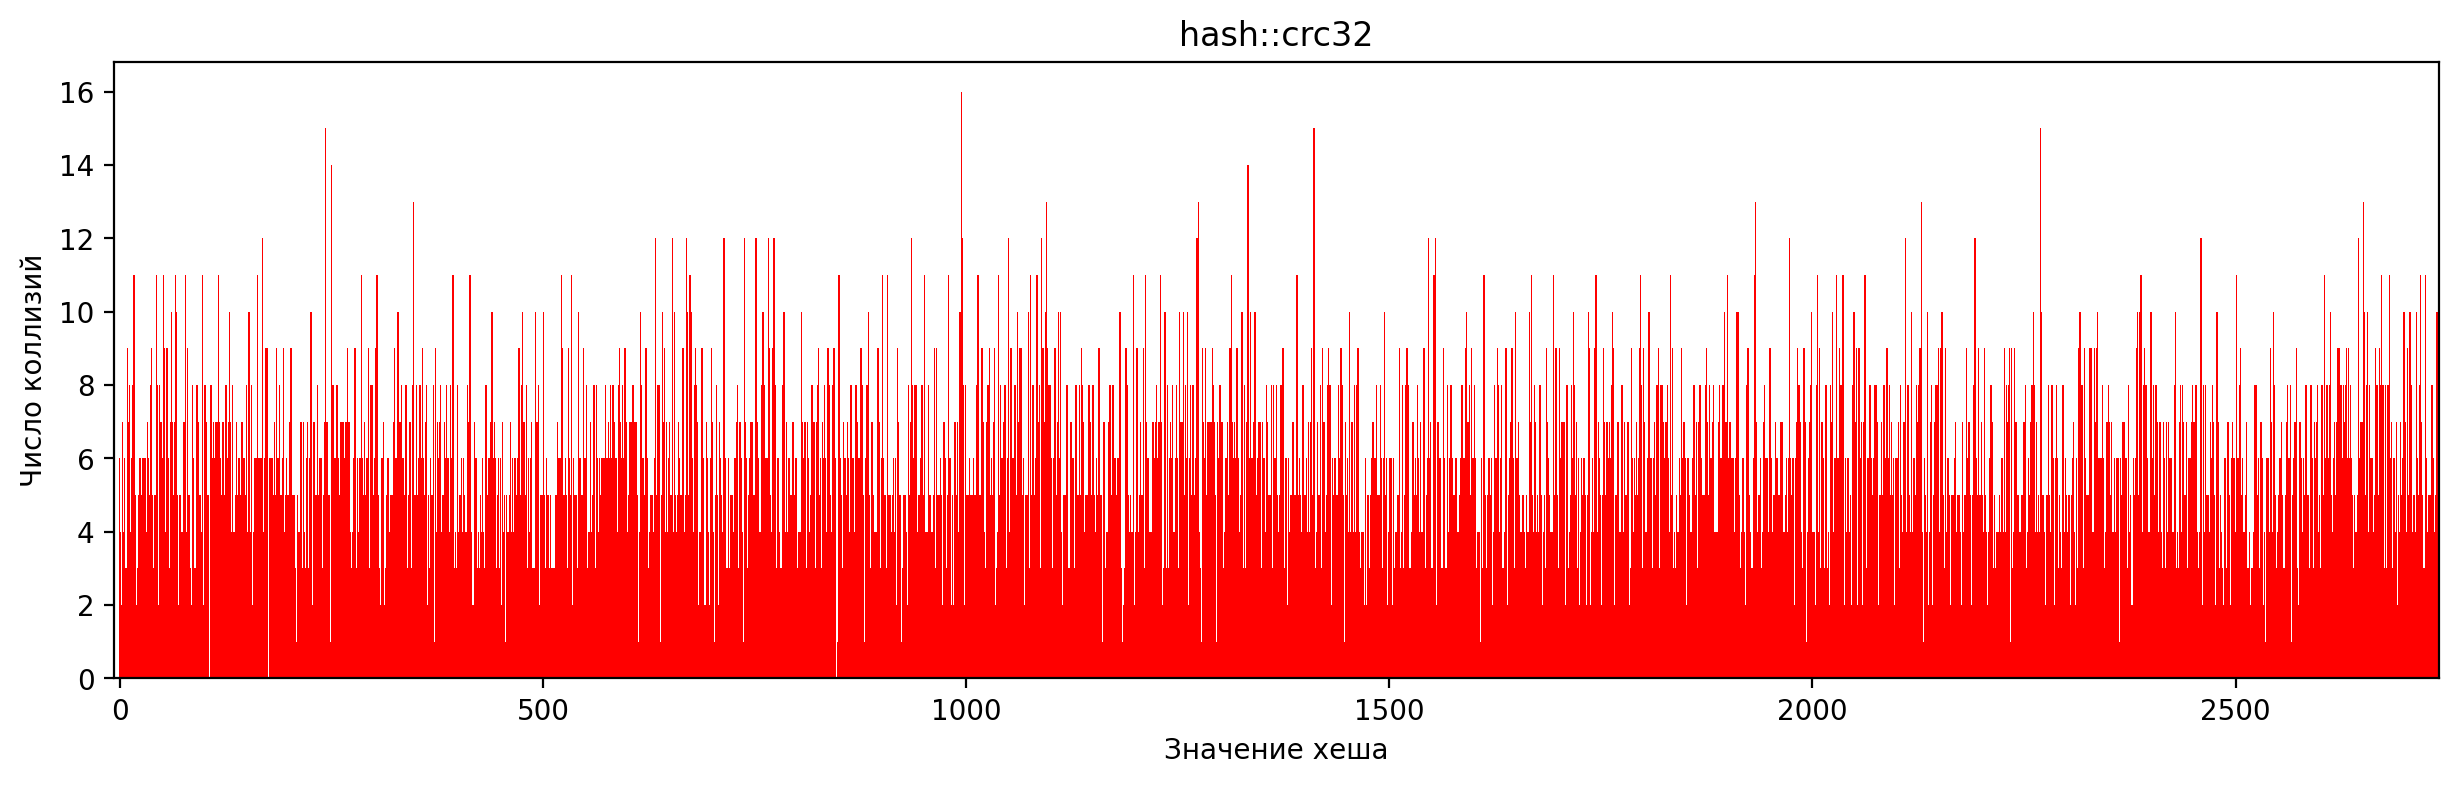

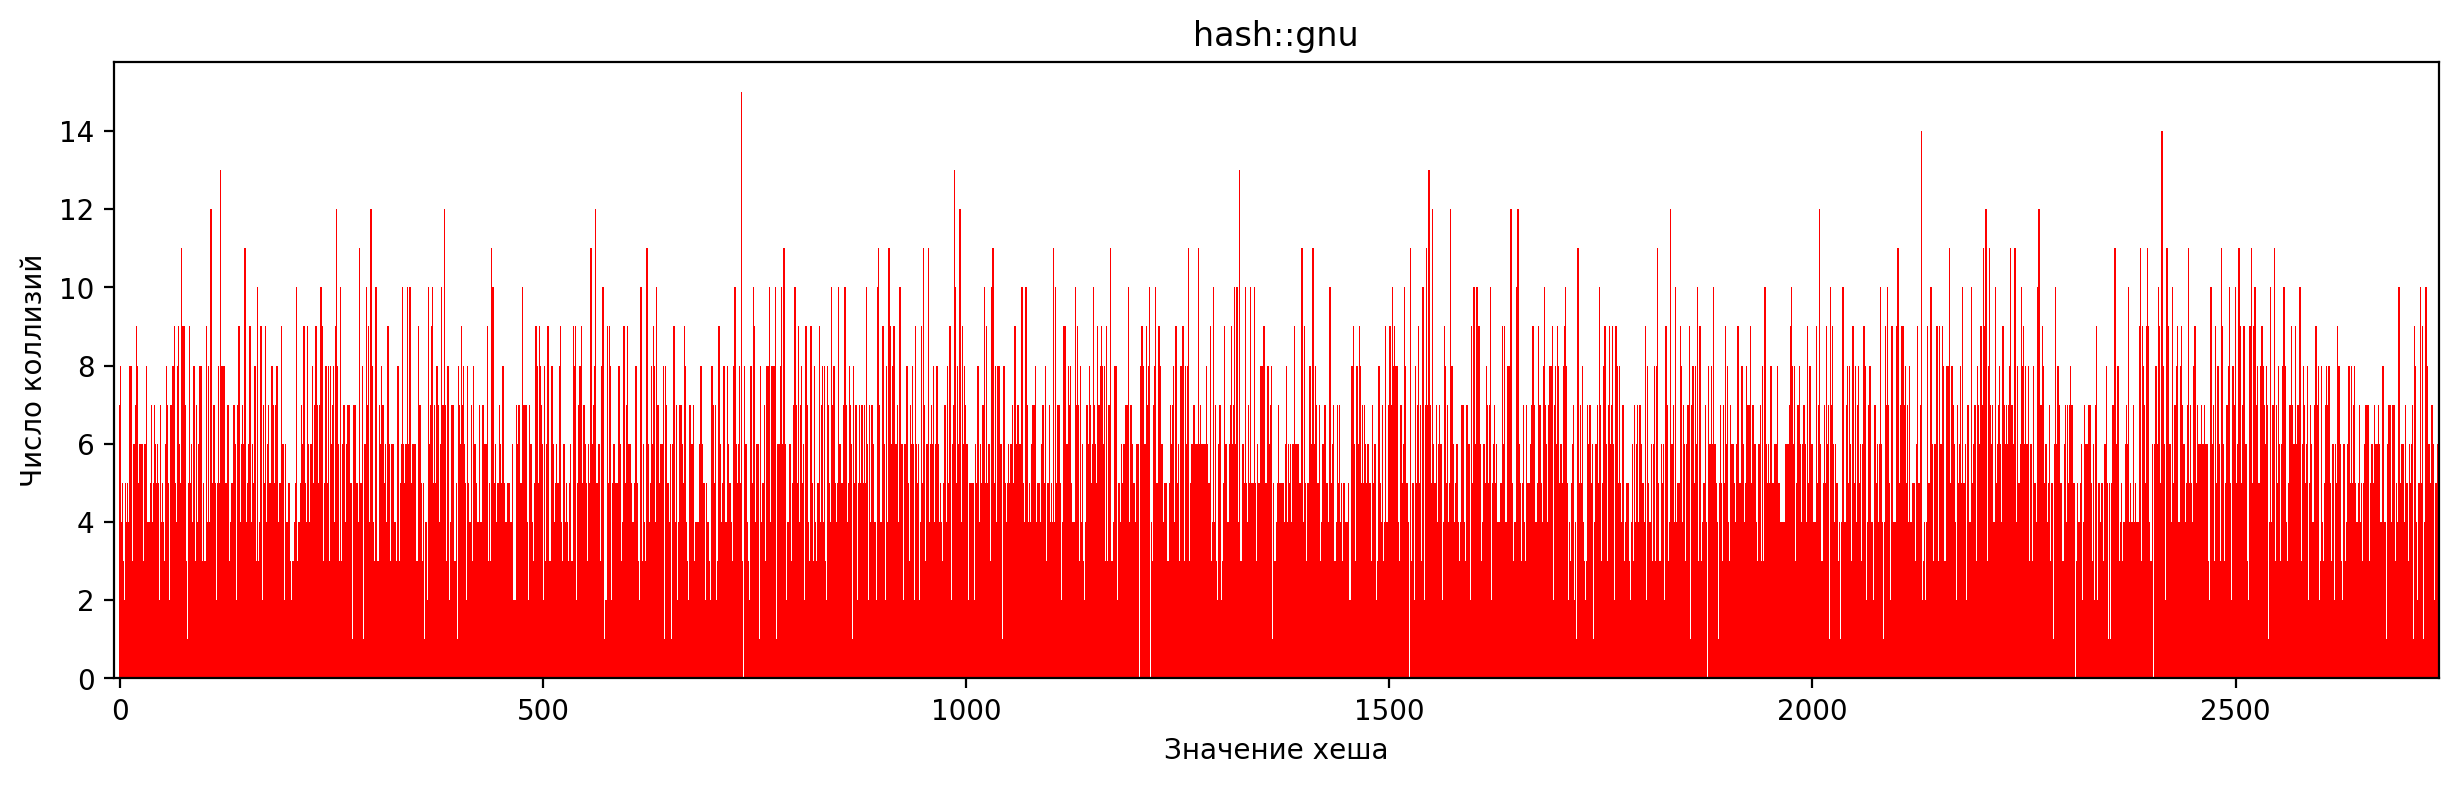

In [31]:
for i in range(nums.__len__()):
    plot_hash_func(nums[i], loads[i], title=HASH_FUNCS[i], xlim=[-0.0025 * max(nums[i]), max(nums[i])])


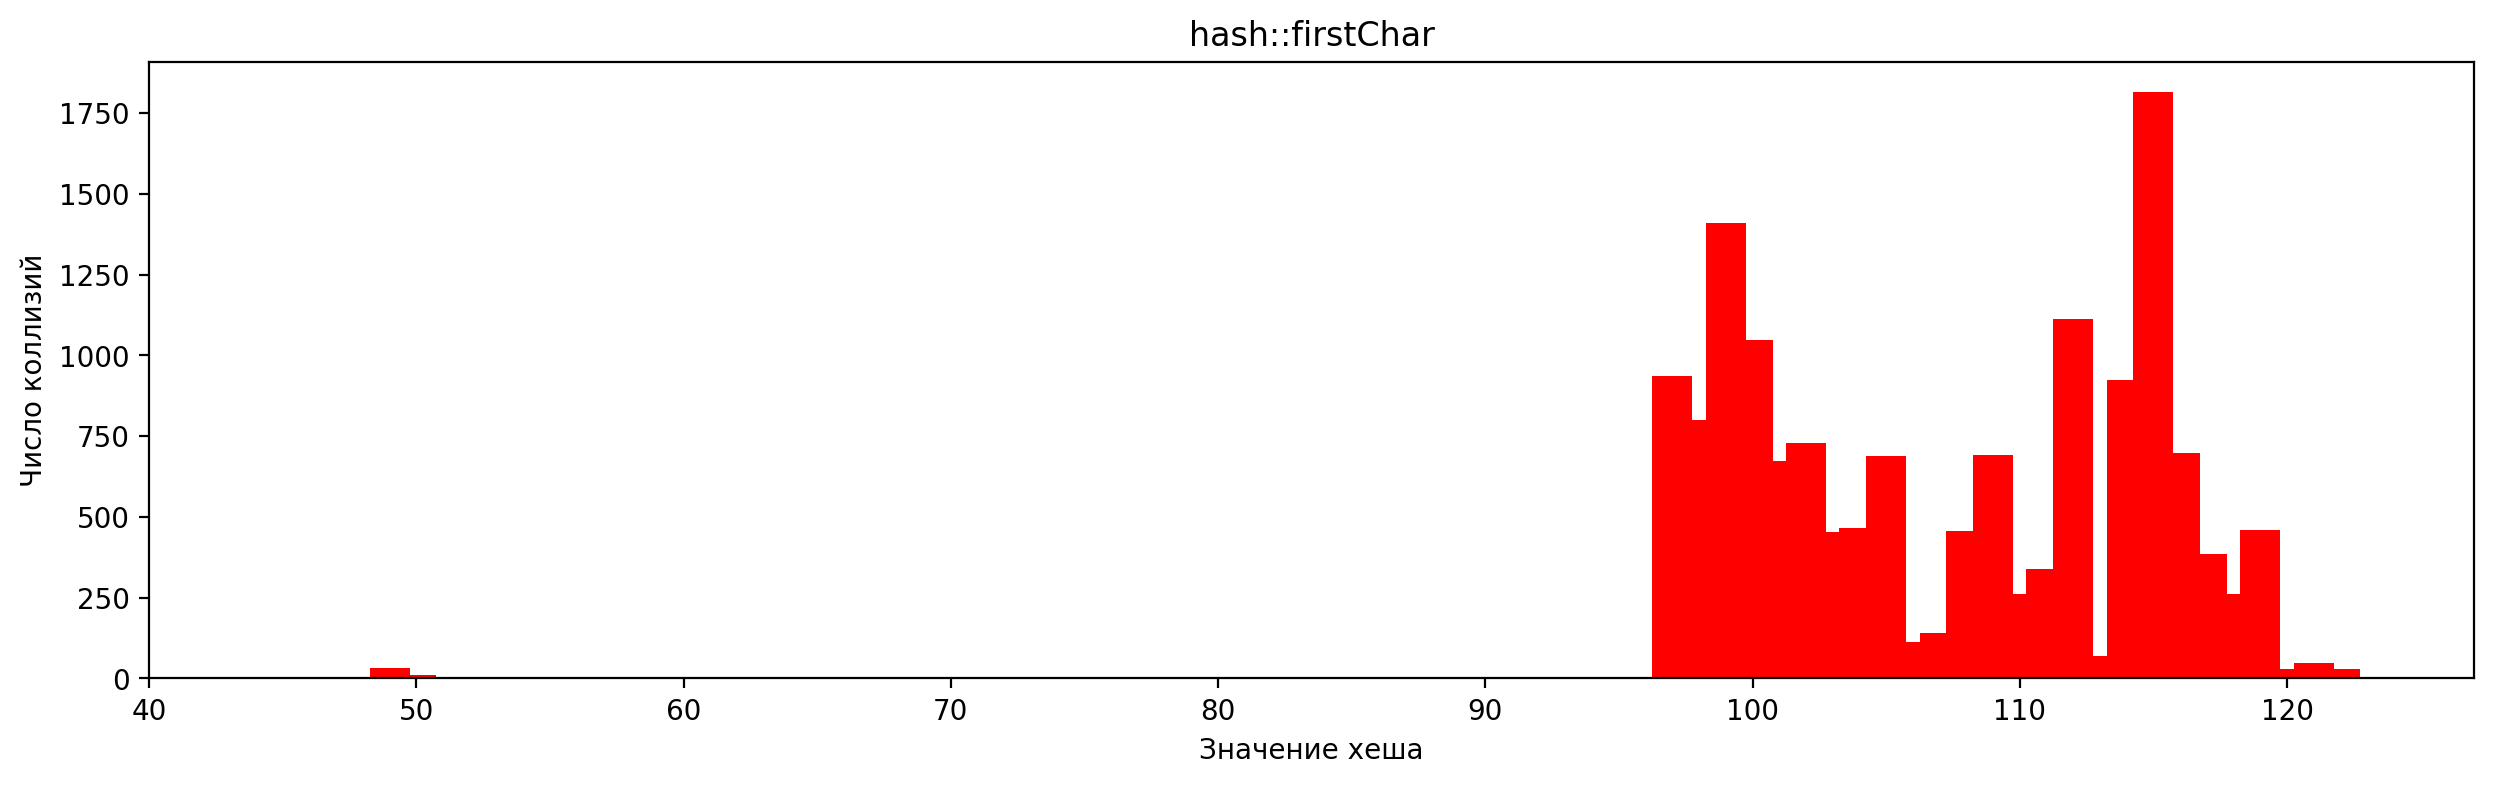

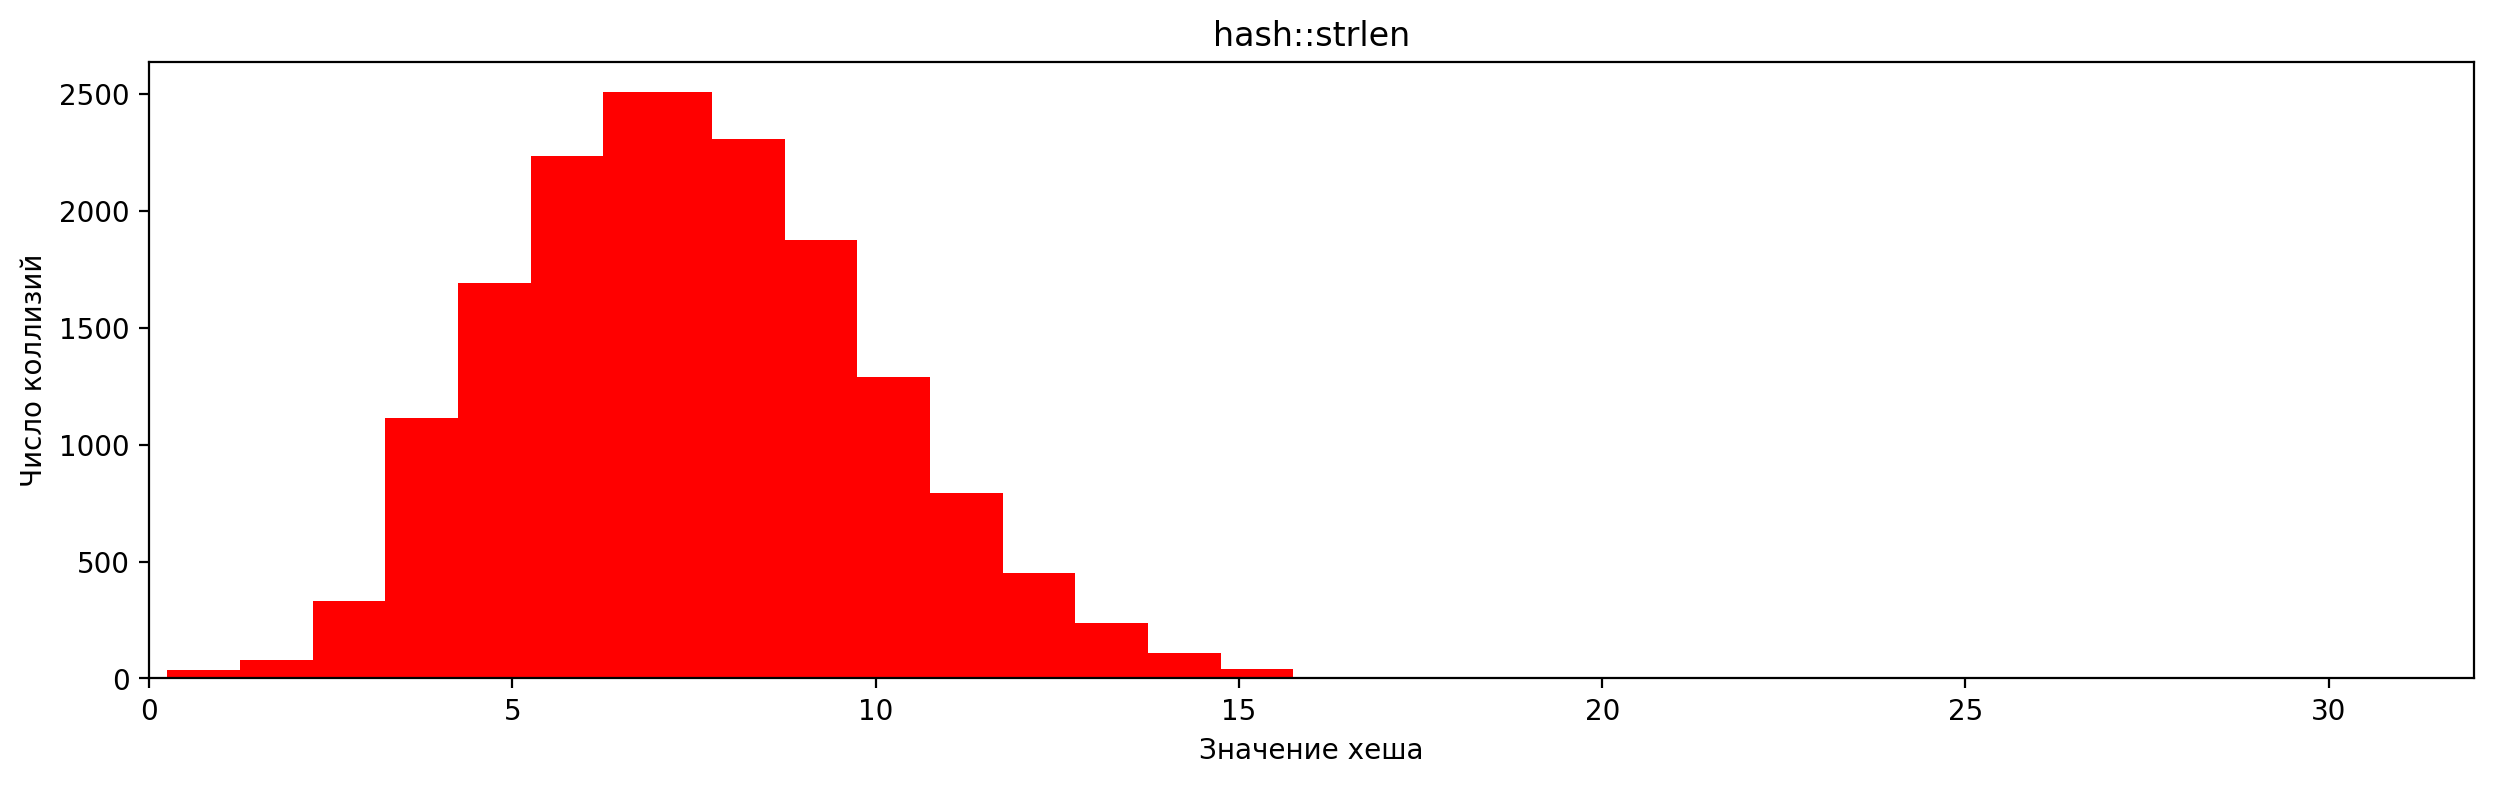

In [32]:
# Detailed bars for hash::firstChar and hash::strlen

xlims = [[0, 0], [40, 127], [0, 32]]

for i in [1, 2]:
    plot_hash_func(nums[i], loads[i], title=f'{HASH_FUNCS[i]}', xlim=xlims[i])

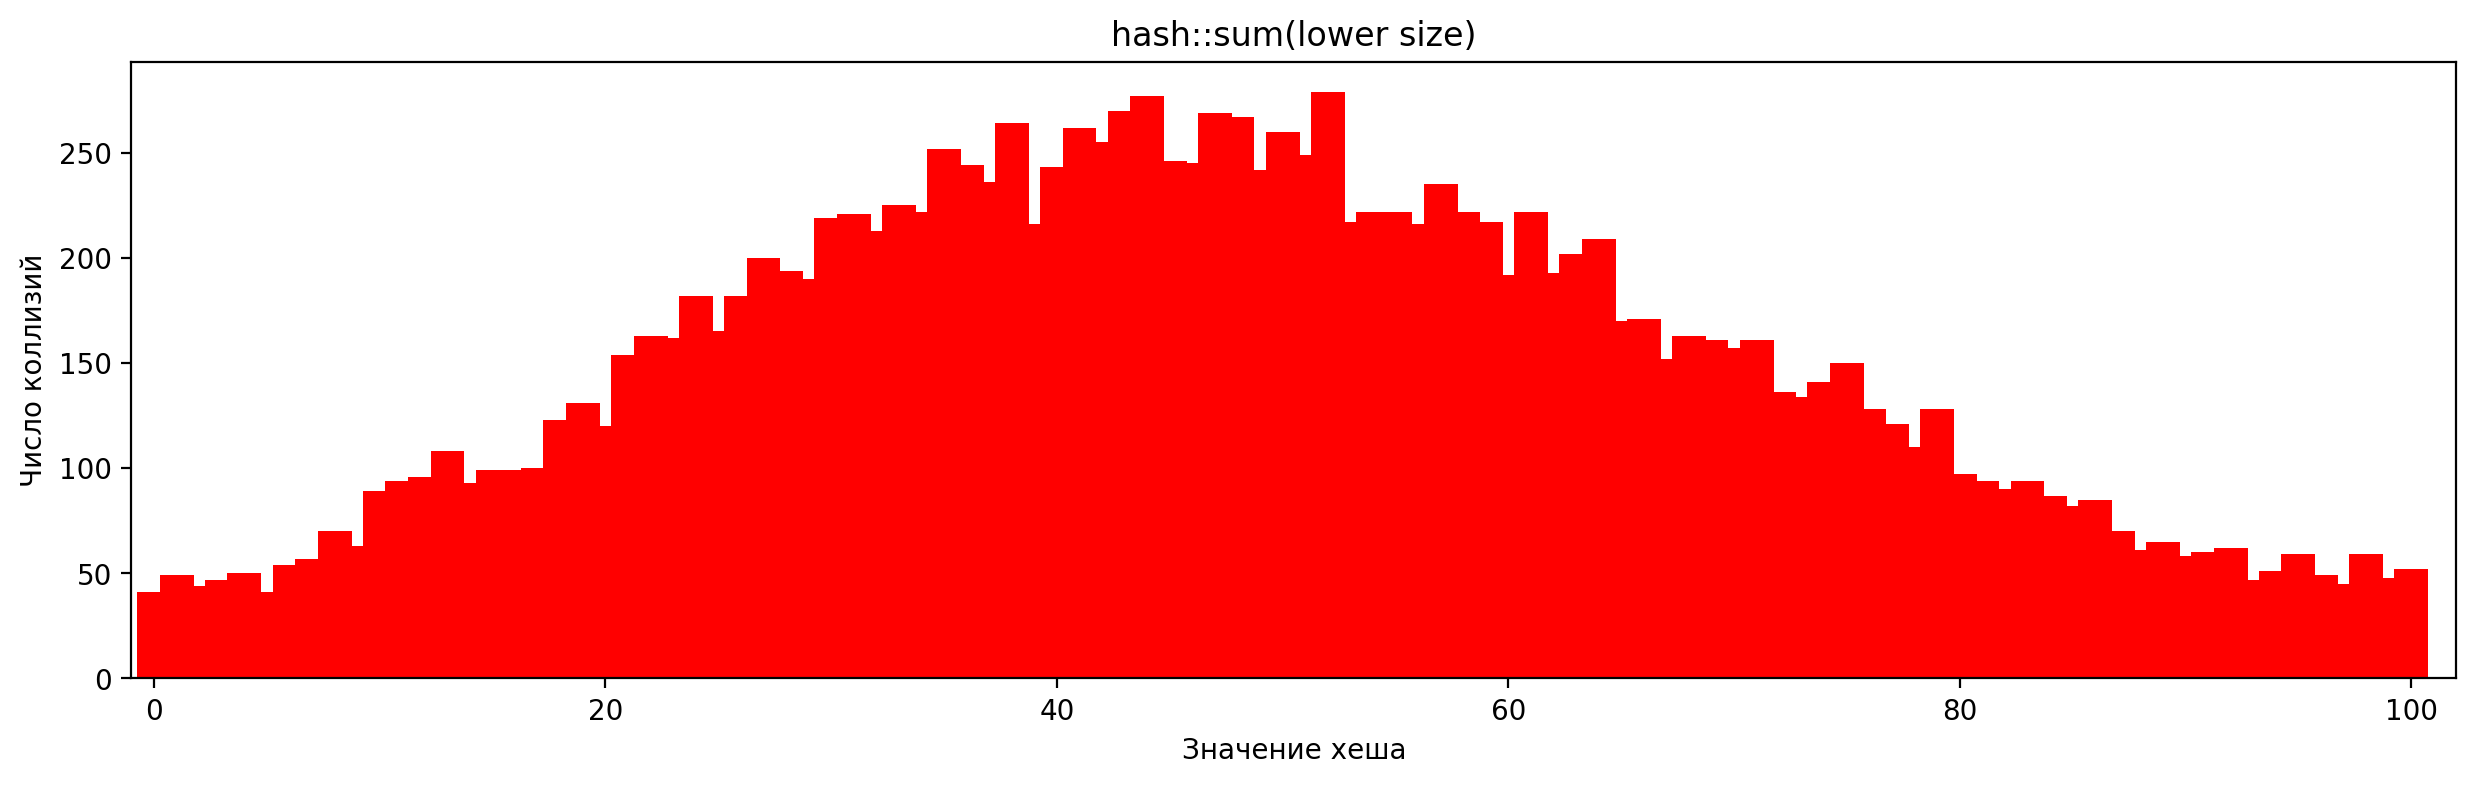

In [33]:
SEPARATE_SUM_HASH_TEST = 'hash::sum(lower size)'

sum_low_size = pd.read_csv(f'{STATS_DIR}/{SEPARATE_SUM_HASH_TEST}.csv')
plot_hash_func(sum_low_size['num'], sum_low_size['load'],
               title=SEPARATE_SUM_HASH_TEST, xlim=[-1, 102])

In [51]:
print('| Хеш | Стандартное отклонение | Время, 1e5 тактов |')
print('|:---:|:----------------------:|:----------:|')

timestats = pd.read_csv('stats/hashtime.csv')

timestats.transpose()

avg_times = [0] * HASH_FUNCS.__len__()
std_times = [0] * HASH_FUNCS.__len__()
devs = [0] * HASH_FUNCS.__len__()

for i in range(HASH_FUNCS.__len__()):
    timevals = np.array(timestats)[i][1:]
    devs[i] = np.std(loads[i])
    avg_times[i] = np.mean(timevals)
    std_times[i] = np.std(timevals)
    if i < 3:
        print(f'| {HASH_FUNCS[i]} | {devs[i]:.0f} | {avg_times[i] // 1e5:.0f} ± {std_times[i] // 1e5:.0f} |')
    elif i == 3:
        print(f'| {HASH_FUNCS[i]} | {devs[i]:.1f} | {avg_times[i] // 1e6:.0f}0 ± {std_times[i] // 1e6:.0f}0 |')
    else:
        print(f'| {HASH_FUNCS[i]} | {devs[i]:.1f} | {avg_times[i] // 1e5:.0f} ± {std_times[i] // 1e5:.0f} |')


| Хеш | Стандартное отклонение | Время, 1e5 тактов |
|:---:|:----------------------:|:----------:|
| hash::zero | 288 | 154 ± 4 |
| hash::firstChar | 70 | 237 ± 4 |
| hash::strlen | 99 | 333 ± 6 |
| hash::sum | 11.6 | 1220 ± 30 |
| hash::ror | 4.4 | 1225 ± 5 |
| hash::rol | 3.2 | 1215 ± 3 |
| hash::crc32 | 2.4 | 3311 ± 2 |
| hash::gnu | 2.4 | 1230 ± 5 |


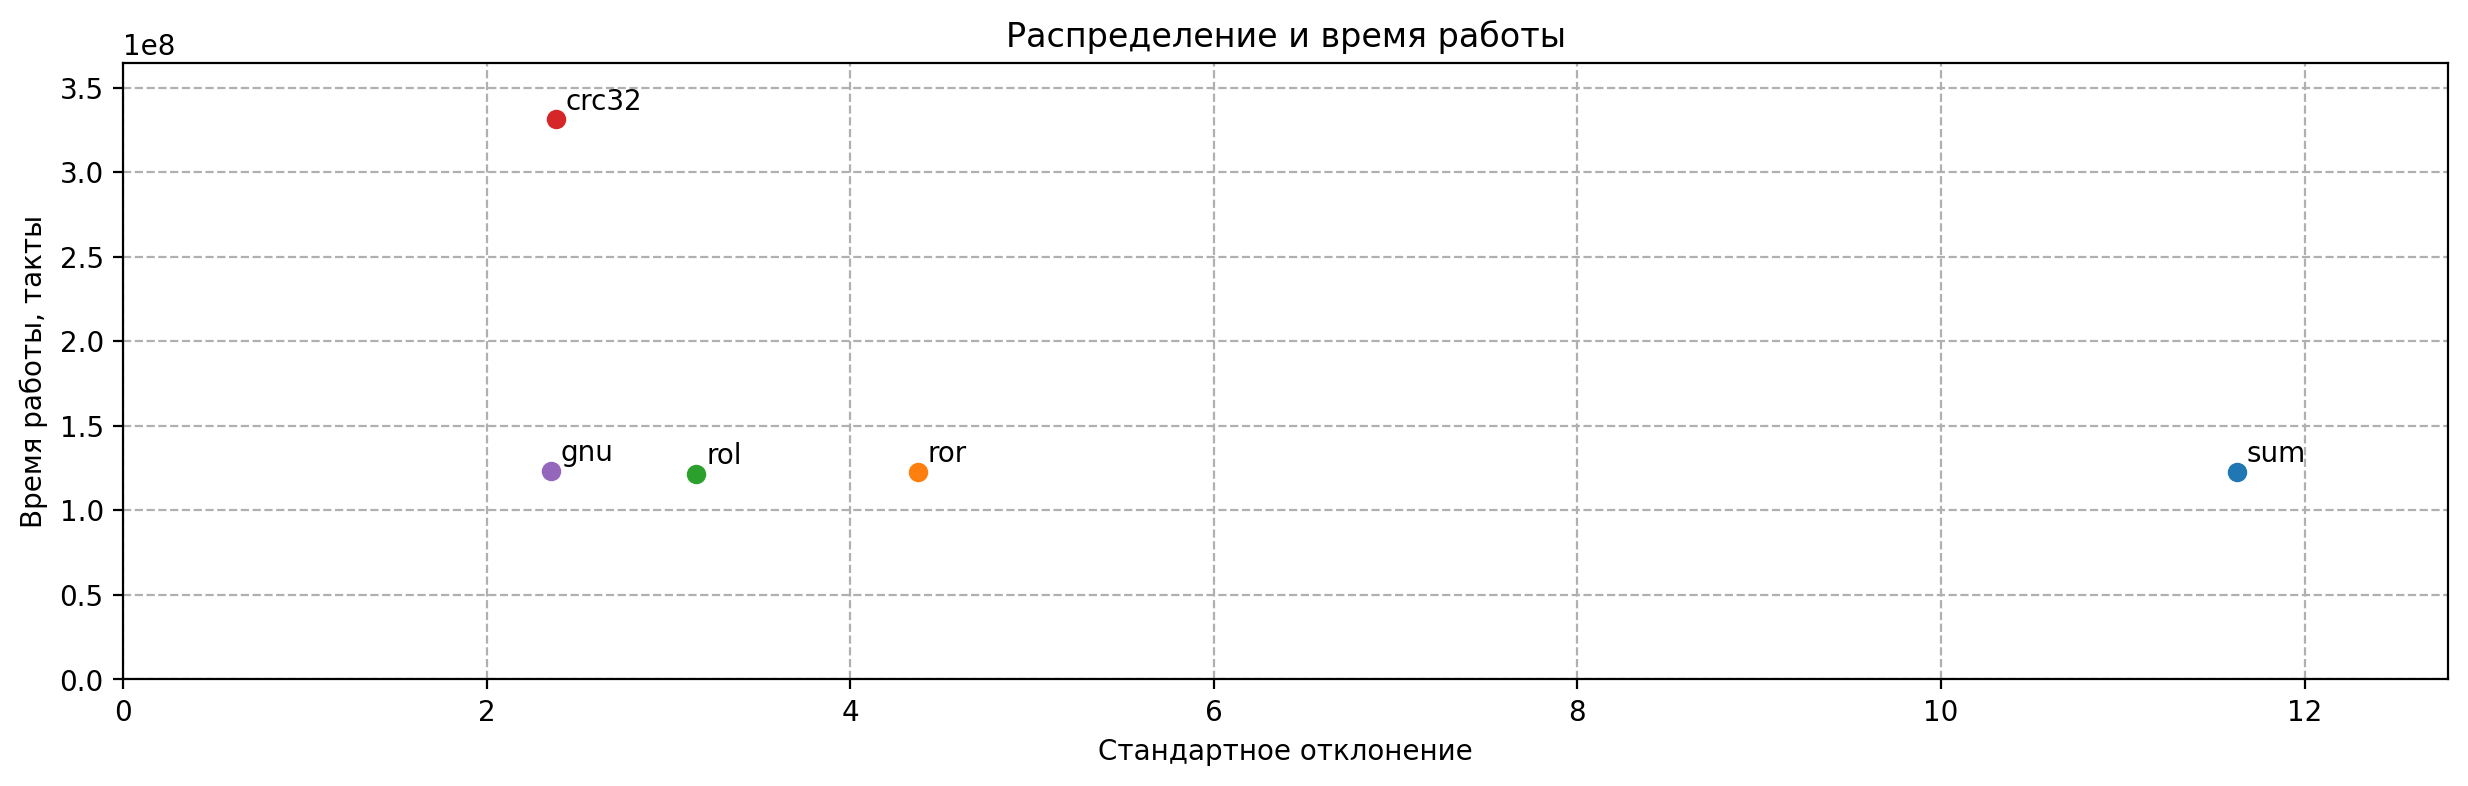

In [49]:
START_INDEX = 3 # не рассматриваем очевидно плохие функции, чтобы раздувать диаграмму

plt.figure(figsize=(15, 4), dpi=200)
plt.xlim(0, max(devs[START_INDEX:]) * 1.1)
plt.ylim(0, max(avg_times[START_INDEX:]) * 1.1)

for i in range(START_INDEX, HASH_FUNCS.__len__()):
    plt.scatter([devs[i]], [avg_times[i]])
    plt.annotate(HASH_FUNCS[i].removeprefix('hash::'), (devs[i], avg_times[i]), xytext=(10, 10),
                 textcoords='offset pixels', size=10)

plt.xlabel('Стандартное отклонение')
plt.ylabel('Время работы, такты')
plt.title('Распределение и время работы')
plt.grid(linestyle='--')
plt.savefig('graphs/dev_time.png')